# SVM with hog, color and LBP

## import libiraries

In [3]:
import numpy as np
import cv2
import tensorflow_datasets as tfds
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from skimage.feature import local_binary_pattern
import matplotlib.pyplot as plt
import random


## Load and split data

In [5]:
dataset, info = tfds.load('caltech101', with_info=True, as_supervised=True)

train_data = dataset['train']
test_data = dataset['test']

## Resize the image to a fixed size (for consistent feature extraction)


In [7]:
def resize_with_padding(image, target_size=(64, 64)):
    h, w = image.shape[:2]
    scale = min(target_size[1] / w, target_size[0] / h)
    resized_image = cv2.resize(image, (int(w * scale), int(h * scale)))
    
    delta_w = target_size[1] - resized_image.shape[1]
    delta_h = target_size[0] - resized_image.shape[0]
    top, bottom = delta_h // 2, delta_h - (delta_h // 2)
    left, right = delta_w // 2, delta_w - (delta_w // 2)
    padded_image = cv2.copyMakeBorder(resized_image, top, bottom, left, right, cv2.BORDER_CONSTANT, value=[0, 0, 0])
    return padded_image

## Preprocess the data 



In [9]:
def process_data(data, image_size=(64, 64)):
    images = []
    labels = []

    for image, label in data:
        # Resize with padding
        image_resized = resize_with_padding(image.numpy(), image_size).astype('float32') / 255.0
        images.append(image_resized)
        labels.append(label.numpy())
    
    return np.array(images), np.array(labels)

## Preprocess the training and testing datasets


In [11]:
X_train, y_train = process_data(train_data, image_size=(64, 64))
X_test, y_test = process_data(test_data, image_size=(64, 64))

## Feature extraction: Combine color histogram and LBP features


In [13]:
def extract_features(images, bins=32):
    features = []

    for image in images:
        # Convert image to BGR format
        image = cv2.cvtColor((image * 255).astype('uint8'), cv2.COLOR_RGB2BGR)
        
        # Initialize combined feature vector
        combined_features = []

        # Compute color histograms
        for channel in range(3):  # B, G, R channels
            hist = cv2.calcHist([image], [channel], None, [bins], [0, 256])
            hist = cv2.normalize(hist, hist).flatten()
            combined_features.extend(hist)
        
        # Compute LBP features
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        lbp = local_binary_pattern(gray_image, P=8, R=1, method="uniform")
        lbp_hist, _ = np.histogram(lbp.ravel(), bins=bins, range=(0, bins))
        lbp_hist = lbp_hist / lbp_hist.sum()  # Normalize
        combined_features.extend(lbp_hist)
        
        # Add combined features to the list
        features.append(combined_features)
    
    return np.array(features)

##  Extract combined features




In [19]:
features_train = extract_features(X_train, bins=32)
features_test = extract_features(X_test, bins=32)

## Training the Kernel SVM model on the Training set



In [21]:
classifier = SVC(kernel='linear', random_state=0)
classifier.fit(features_train, y_train)


SVC(kernel='linear', random_state=0)

## Predict the labels for the test set


In [23]:
y_pred = classifier.predict(features_test)


## Calculate accuracy

In [25]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

Test Accuracy: 33.31%


## Print classification report


In [27]:
print("\nClassification Report:")
print(classification_report(y_test.flatten(), y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.03      0.32      0.05        25
           1       0.79      0.94      0.86       770
           2       0.00      0.00      0.00        12
           3       0.00      0.00      0.00        12
           4       1.00      0.00      0.00       438
           5       0.00      0.00      0.00        17
           6       0.05      0.17      0.07        24
           7       0.00      0.00      0.00        16
           8       0.00      0.00      0.00         3
           9       0.00      0.00      0.00        98
          10       0.12      0.04      0.07        68
          11       0.00      0.00      0.00        13
          12       0.00      0.00      0.00        55
          13       0.00      0.00      0.00        61
          14       0.11      0.30      0.16        20
          15       0.00      0.00      0.00        13
          16       0.23      0.83      0.36        93
   

C:\Users\Ahmedmohamed\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Ahmedmohamed\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Ahmedmohamed\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## Visualize a random image, its HOG features, and the SVM prediction


In [33]:
def show_image_with_features_and_prediction(images, labels, classifier, bins=32):
    # Select a random image index
    index = random.randint(0, len(images) - 1)
    original_image = (images[index] * 255).astype('uint8')
    true_label = labels[index]
    
    # Extract features for the selected image
    bgr_image = cv2.cvtColor(original_image, cv2.COLOR_RGB2BGR)
    
    # Color histogram features
    color_features = []
    for channel in range(3):  # B, G, R channels
        hist = cv2.calcHist([bgr_image], [channel], None, [bins], [0, 256])
        hist = cv2.normalize(hist, hist).flatten()
        color_features.extend(hist)
    
    # LBP features
    gray_image = cv2.cvtColor(bgr_image, cv2.COLOR_BGR2GRAY)
    lbp = local_binary_pattern(gray_image, P=8, R=1, method="uniform")
    lbp_hist, _ = np.histogram(lbp.ravel(), bins=bins, range=(0, bins))
    lbp_hist = lbp_hist / lbp_hist.sum()  # Normalize
    
    # Concatenate features
    combined_features = np.hstack((color_features, lbp_hist))
    
    # Predict the label
    predicted_label = classifier.predict([combined_features])[0]
    
    # Visualize the original image and features
    plt.figure(figsize=(12, 6))
    
    # Original image
    plt.subplot(1, 3, 1)
    plt.imshow(original_image)
    plt.title(f"Original Image\nTrue Label: {true_label}")
    plt.axis("off")
    
    # Visualization of concatenated features
    plt.subplot(1, 3, 2)
    plt.imshow(lbp, cmap="gray")
    plt.title("LBP Features\n(Part of Concatenated Features)")
    plt.axis("off")
    
    # Prediction visualization
    plt.subplot(1, 3, 3)
    plt.imshow(original_image)
    plt.title(f"Prediction: {predicted_label}\nTrue Label: {true_label}")
    plt.axis("off")
    
    plt.tight_layout()
    plt.show()

## Display a random image, its HOG features, and the prediction


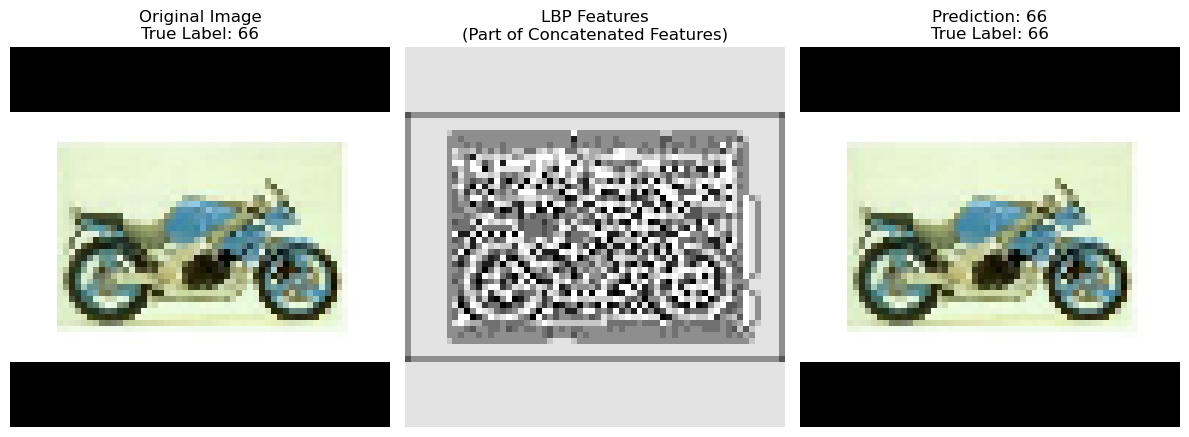

In [38]:
show_image_with_features_and_prediction(X_test, y_test, classifier, bins=32)
